In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

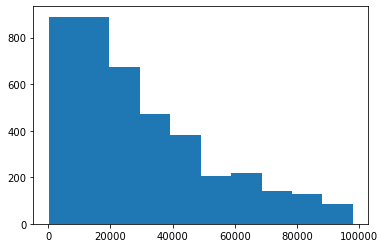

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

#add a categorical value for large vs small mkts
cutoff = 1e5
plt.hist(df['DP03_0095E'][df['DP03_0095E'] < 1e5] )
X['large_mkt'] = 1*(df['DP03_0095E'] > 1e5)

In [3]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), y, test_size=test_size)

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_pred < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

mse Ever Enrolled Count    1.552937e+07
dtype: float64


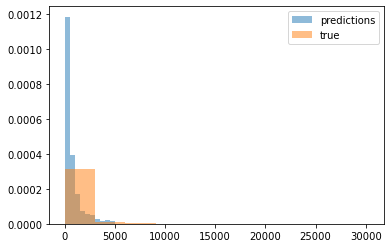

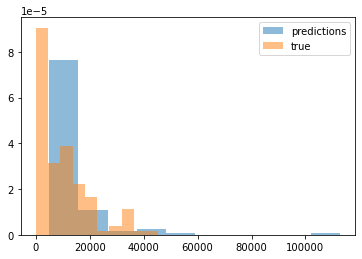

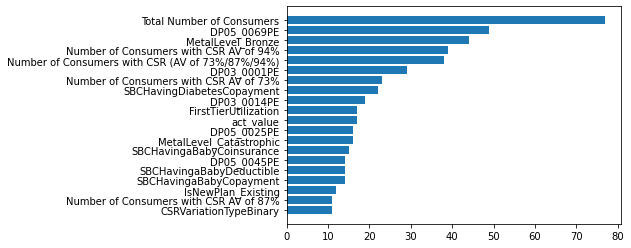

In [5]:
# not super deep, but uses most of the data at one
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=2, eta=.5, subsample=0.9, colsample_bytree=.9)
model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

mse Ever Enrolled Count    4.282368e+07
dtype: float64


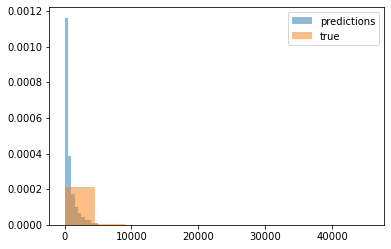

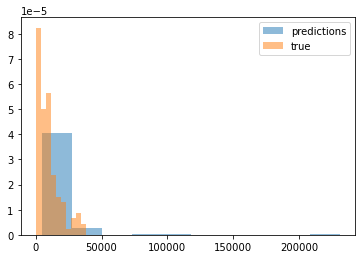

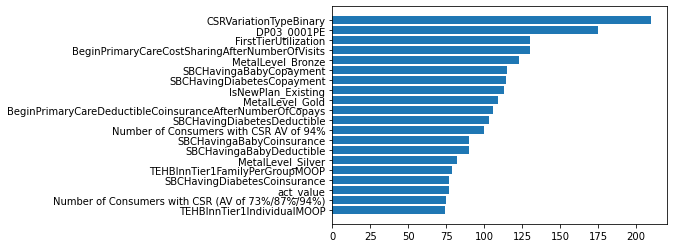

In [6]:
#uses much less data, the covariates seem more accurate...
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=5, eta=.5, subsample=0.5, colsample_bytree=.9)
model.fit(X_train, y_train)

model.fit(X_train, y_train)

y_pred = get_predictions(model,X_test)
print( 'mse', ((y_test - y_pred)**2).mean() ) 

#plot the difference between true and predicted
split = 5000
plot_prediction(split,y_pred,y_test)

plot_importance(X_test,model)

alpha_value: 50 mse Ever Enrolled Count    1.016151e+07
dtype: float64


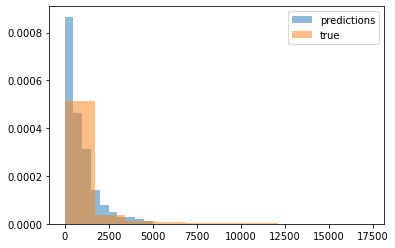

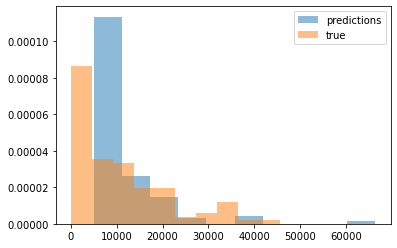

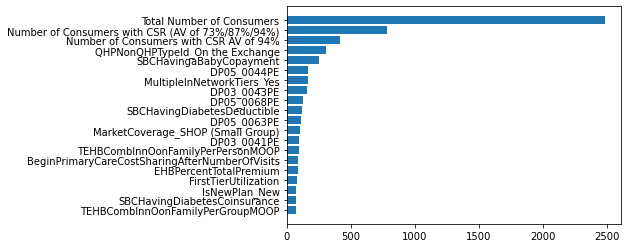

alpha_value: 100 mse Ever Enrolled Count    1.007616e+07
dtype: float64


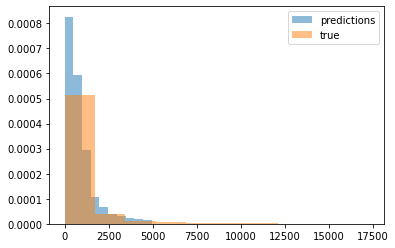

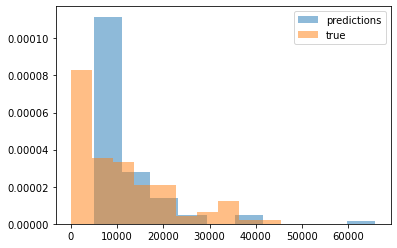

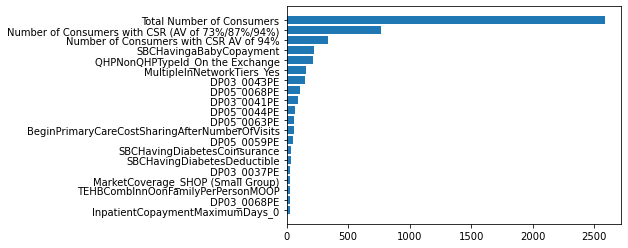

alpha_value: 150 mse Ever Enrolled Count    1.002697e+07
dtype: float64


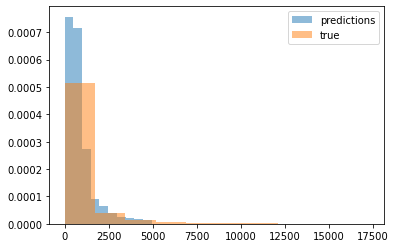

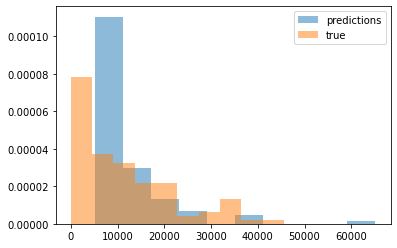

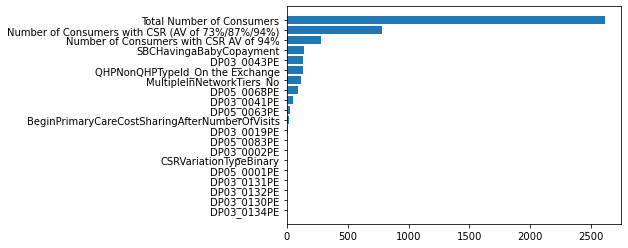

alpha_value: 200 mse Ever Enrolled Count    1.004836e+07
dtype: float64


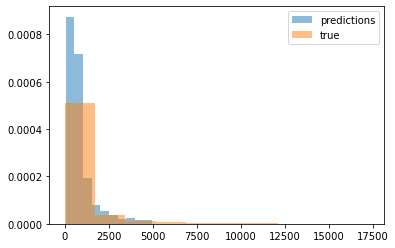

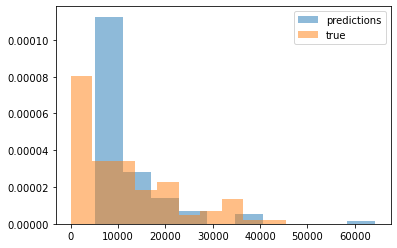

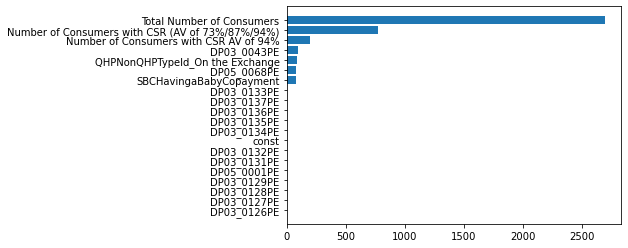

alpha_value: 250 mse Ever Enrolled Count    1.001782e+07
dtype: float64


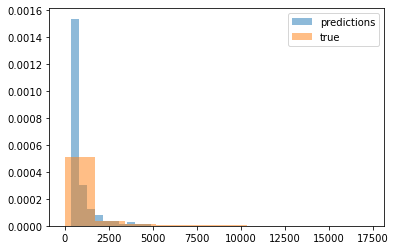

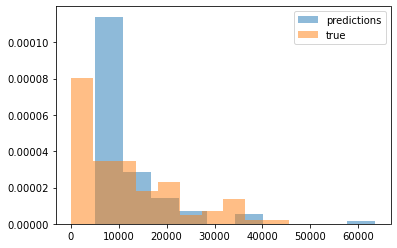

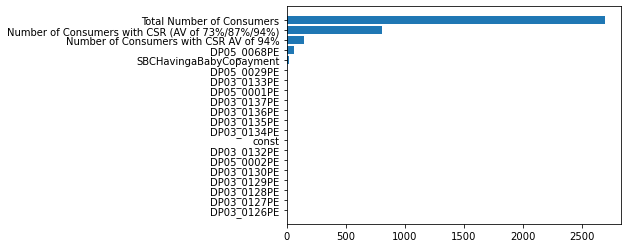

In [7]:
# Vary alpha values
a = [50,100,150,200,250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,X_test)
    
    print('alpha_value:', i, 'mse', ((y_test - y_pred)**2).mean()) 
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()